In [1]:
cd /home/tkim/Academics/EdgeAlloc/

/home/tkim/Academics/EdgeAlloc


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

# Import tools
import tools.solver_utils as ts
import tools.other_utils as to
import tools.sim_utils as tm

# Import classes
from classes.User import *
from classes.Server import *

import pdb

np.set_printoptions(suppress=True, precision=4)

In [4]:
# testing user markov chain 
U = 7
K = 4
T = 5000

space_1d_dim = 6
num_locs = 9
cap_multiply = 2

# Generate visitng locations and server locations
usr_locs = tm.gen_eq_locs(space_1d=space_1d_dim, nums=num_locs, offset = 1.7)
svr_locs = tm.gen_eq_locs(space_1d=space_1d_dim, nums=K, offset = 1.7)
C = np.ones(K) * cap_multiply
C2 = np.append(C,np.array([1]))

mu = np.random.uniform(low=0.0, high=1.0, size=[U,K])
mu2 = np.append(mu, np.zeros([U,1]), axis = 1)

servers = []
for s in range(len(svr_locs)):
    servers += [Server(C[s], s, mu, svr_locs[s])]

users = []
for i in range(U):
    users += [User(servers, T, usr_locs, lat_dist = 4.5, self_weight = 0.25, threshold_dist=3.5)]
    
usersR = copy.deepcopy(users)
usersR2 = copy.deepcopy(users)
    
# Naive
regret_dist = np.zeros(T)
collision_loss = np.zeros(T)
collision_rate = np.zeros(T)

# Reserve - OG
regret_R = np.zeros(T)
collision_loss_R = np.zeros(T)
collision_rate_R = np.zeros(T)

# Reserve - Var Length
regret_R2 = np.zeros(T)
collision_loss_R2 = np.zeros(T)
collision_rate_R2 = np.zeros(T)

# Central solver
UCB = np.ones_like(mu)
T_ka = np.ones_like(mu)
rewards_sum = np.ones([U,K]) # Just for calculating UCB idx
regret_central = np.zeros(T)

pbar = tqdm(total=T - K)

for t in range(T - K):
    
    # Obtain New Arm availability
    L = to.obtain_L_users(U,K,users)
    
    # Optimal placement and reward
    opt_x, opt_reward = ts.solve_optimization(mu, C, L)
    
    # Solve for Central
    lrn_x, _ = ts.solve_optimization(UCB, C, L)
    lrn_reward = ts.calculate_obj_val(lrn_x, mu, C)
    regret_central[t] = opt_reward - lrn_reward
    UCB, T_ka, rewards_sum, mu_bar = ts.play_UCB(UCB, T_ka, rewards_sum, t+1, mu, lrn_x)
    
    # Solve Naive - Distributed 
    lrn_x_dist = tm.dist_usr_arms(users)
    lrn_reward_dist = ts.calculate_obj_val(lrn_x_dist, mu2, C2)
    regret_dist[t] = opt_reward - lrn_reward_dist
    tm.dist_receive_rewards(servers, users, lrn_x_dist)
    
    # Solve Reserve - Distributed
    lrn_x_R = tm.dist_usr_arms(usersR)
    lrn_reward_R = ts.calculate_obj_val(lrn_x_R, mu2, C2)
    regret_R[t] = opt_reward - lrn_reward_R
    tm.dist_receive_rewards(servers, usersR, lrn_x_R, rsv_flag = True, wait_scale = 1, rsv_dynamic = False)
    
    # Solve Reserve - Distributed Var Length
    lrn_x_R2 = tm.dist_usr_arms(usersR2)
    lrn_reward_R2 = ts.calculate_obj_val(lrn_x_R2, mu2, C2)
    regret_R2[t] = opt_reward - lrn_reward_R2
    tm.dist_receive_rewards(servers, usersR2, lrn_x_R2, rsv_flag = True, wait_scale = 1,rsv_dynamic = True)
    
    # Obtain Collision Information for Dist Methods
    collision_loss[t], collision_rate[t] = tm.characterize_collision(lrn_x_dist, mu2, C2)
    collision_loss_R[t], collision_rate_R[t] = tm.characterize_collision(lrn_x_R, mu2, C2)
    
    # Update for Next Step
    for u in users:
        u.next_step()
    for i in range(len(usersR)):
        usersR[i].next_step()
        usersR[i].usr_place = copy.deepcopy(users[i].usr_place)
    pbar.update(1)
    
pbar.close()

  0%|          | 0/4996 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2024-10-28


100%|██████████| 4996/4996 [04:35<00:00, 18.01it/s]


Cumul Regret: 4218.957579703415


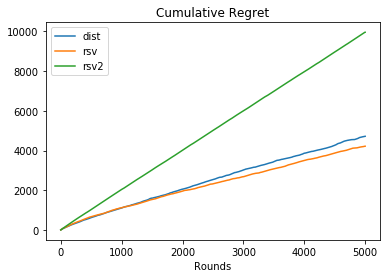

In [5]:
plt.plot(np.cumsum(regret_dist), label = 'dist')
plt.plot(np.cumsum(regret_R), label = 'rsv')
plt.plot(np.cumsum(regret_R2), label = 'rsv2')

plt.title("Cumulative Regret")
plt.xlabel("Rounds")
plt.legend()

print("Cumul Regret:", np.cumsum(regret_R)[-1])

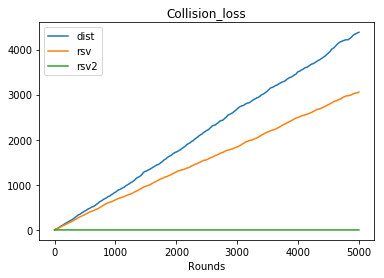

In [6]:
plt.plot(np.cumsum(collision_loss), label = 'dist')
plt.plot(np.cumsum(collision_loss_R), label = 'rsv')
plt.plot(np.cumsum(collision_loss_R2), label = 'rsv2')

plt.title("Collision_loss")
plt.xlabel("Rounds")
plt.legend()

In [7]:
min(1,2)

1